In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

import os

In [2]:
model_dict = {
    'efficientnet_B0':      {},
    # 'googlenet':            {},       
    'mobilenet_v3_small':   {},
    'mobilenet_v3_large':   {},
    # 'regnet_y_400mf':       {},
    'regnet_y_800mf':       {},
    # 'regnet_x_400mf':       {},
    'regnet_x_800mf':       {},
    'resnet18':             {},
    # 'shufflenet_v2_x0_5':   {},
    'shufflenet_v2_x1_0':   {},
    'shufflenet_v2_x1_5':   {},   
}

cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(model_dict.keys())))
print(colors)

[[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


In [3]:
cut_heights = [10, 40, 70, 100]

for ch in cut_heights:
    basepath = f'./checkpoints-{ch}-single-label-final'

    files = os.listdir(basepath)
    files = [f for f in files if f.endswith('.xlsx') and '~$' not in f]

    for n,key in enumerate(model_dict.keys()):
        model_dict[key][f'files-{ch}'] = [f for f in files if key in f]
        model_dict[key]['color'] = colors[n]

In [4]:
display(model_dict)

{'efficientnet_B0': {'files-10': ['model-AW-TT-efficientnet_B0-None-SGD-lr-0.000968-n_filters-128-n_layers-2-bs-24-rf-3-ch-10-aug_p-0.40-acc-0.5284-f1-0.5324-f1_lbl-0.3978-auroc-0.9008-ep-109.xlsx',
   'model-AW-TT-efficientnet_B0-None-Adam-lr-0.000101-n_filters-32-n_layers-2-bs-24-rf-3-ch-10-aug_p-0.40-acc-0.5058-f1-0.5196-f1_lbl-0.3570-auroc-0.8999-ep-85.xlsx'],
  'color': array([0.267004, 0.004874, 0.329415, 1.      ]),
  'files-40': ['model-AW-TT-efficientnet_B0-None-SGD-lr-0.001440-n_filters-64-n_layers-1-bs-24-rf-3-ch-40-aug_p-0.30-acc-0.5658-f1-0.5392-f1_lbl-0.4018-auroc-0.9004.xlsx',
   'model-AW-TT-efficientnet_B0-None-SGD-lr-0.008331-n_filters-32-n_layers-2-bs-24-rf-3-ch-40-aug_p-0.80-acc-0.5977-f1-0.5493-f1_lbl-0.4440-auroc-0.8769.xlsx'],
  'files-70': ['model-AW-TT-efficientnet_B0-None-SGD-lr-0.005265-n_filters-16-n_layers-4-bs-24-rf-3-ch-70-aug_p-0.10-acc-0.5254-f1-0.5286-f1_lbl-0.3838-auroc-0.8739.xlsx'],
  'files-100': []},
 'mobilenet_v3_small': {'files-10': ['model-AW-

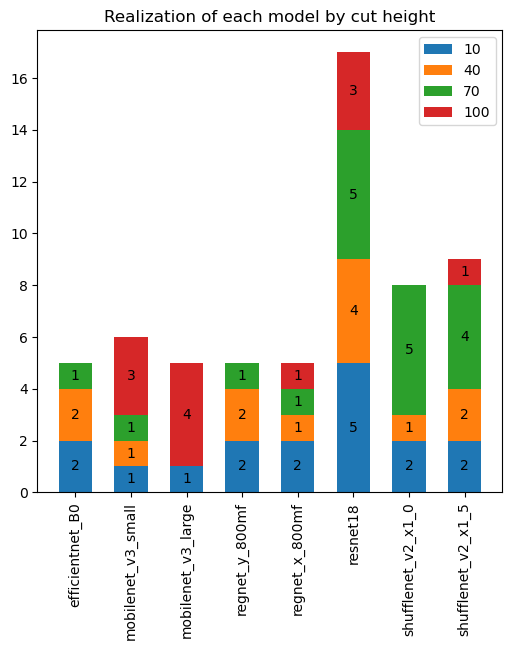

In [5]:
xlabel = tuple(model_dict.keys())

data = {
    ch: [len(model_dict[key][f'files-{ch}']) for key in model_dict.keys()] for ch in cut_heights
}

width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(6,6))
bottom = np.zeros(len(xlabel))

for ch, ch_count in data.items():
    p = ax.bar(xlabel, ch_count, width, label=ch, bottom=bottom)
    bottom += ch_count

    labels = [v if v > 0 else "" for v in ch_count]
    ax.bar_label(p, labels=labels, label_type='center')

ax.set_title('Realization of each model by cut height')
ax.tick_params(axis='x', rotation=90)

# dx = -0.15; dy = 0. 
# offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# for lbl in ax.xaxis.get_majorticklabels():
#     lbl.set_transform(lbl.get_transform() + offset)

ax.legend()

plt.show()

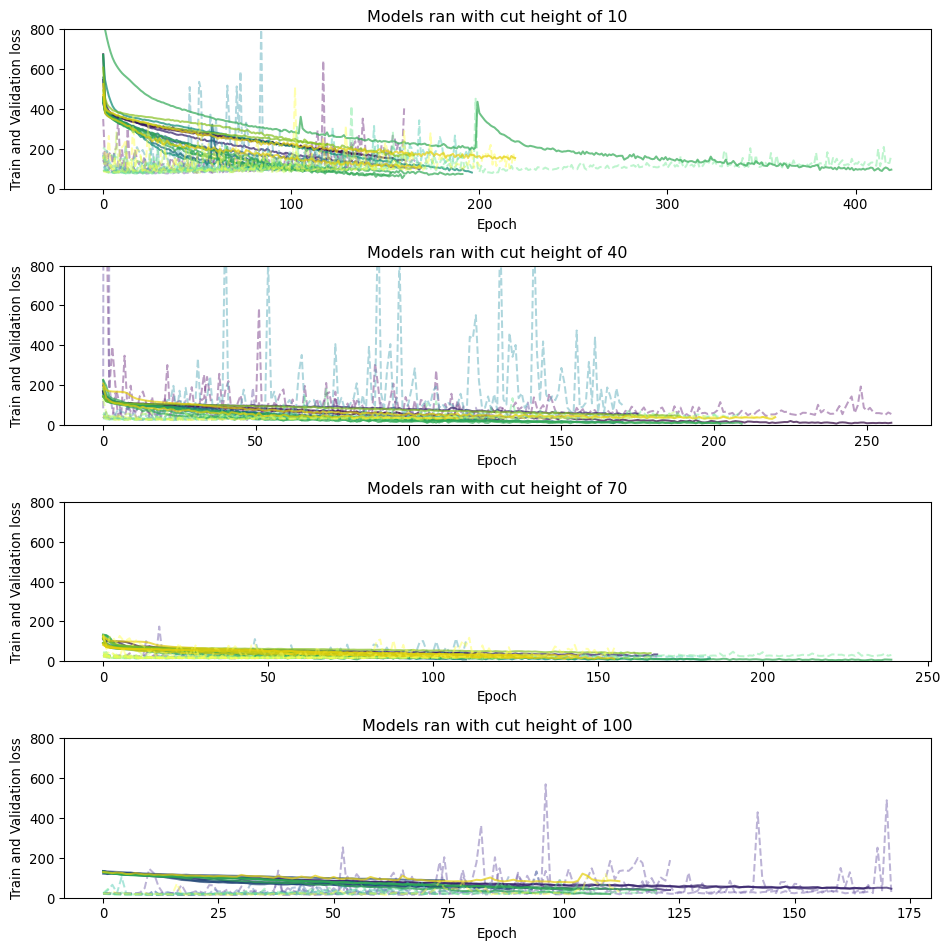

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), dpi=96)

for n,ch in enumerate(cut_heights):
    basepath = f'./checkpoints-{ch}-single-label-final'
    for key in model_dict.keys():
        color = model_dict[key]['color']

        color_train = np.clip(np.add(color, (-.1, -.1, -.1, 0.)), 0, 1)
        color_val = np.clip(np.add(color, (.15, .15, .15, 0.)), 0, 1)

        for experiment_file in model_dict[key][f'files-{ch}']:
            df = pd.read_excel(f'{basepath}/{experiment_file}', index_col = 0)              

            axs[n].plot(df['epoch'], df['validation-loss'], '--', color=color_val, alpha=.45)#, label='validation-loss')
            axs[n].plot(df['epoch'], df['train-loss'], '-', color=color_train, alpha=.7)#, label='train-loss')

            if ch == 10 and 'ep' in experiment_file:
                best_epoch = int(experiment_file.split('-')[-1][:-5])
                axs[n].plot([best_epoch], [df['validation-loss'].iloc[best_epoch]], color=color_val, markersize=50)

    # plt.legend()
    # axs[n].set_yscale('log')
    axs[n].set_ylim(0, 800)
    axs[n].set_title(f'Models ran with cut height of {ch}')
    axs[n].set_ylabel('Train and Validation loss')
    axs[n].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

In [7]:
res = re.match(r".+-acc-([\d.]{5,6})-f1-([\d.]{5,6})-.+-auroc-([\d.]{5,6}).+", 
               "model-AW-TT-efficientnet_B0-None-Adam-lr-0.000101-n_filters-32-n_layers-2-bs-24-rf-3-ch-10-aug_p-0.40-acc-0.5058-f1-0.5196-f1_lbl-0.3570-auroc-0.8999-ep-85.xlsx")
print(*res.groups())

0.5058 0.5196 0.8999


In [8]:
import seaborn as sns

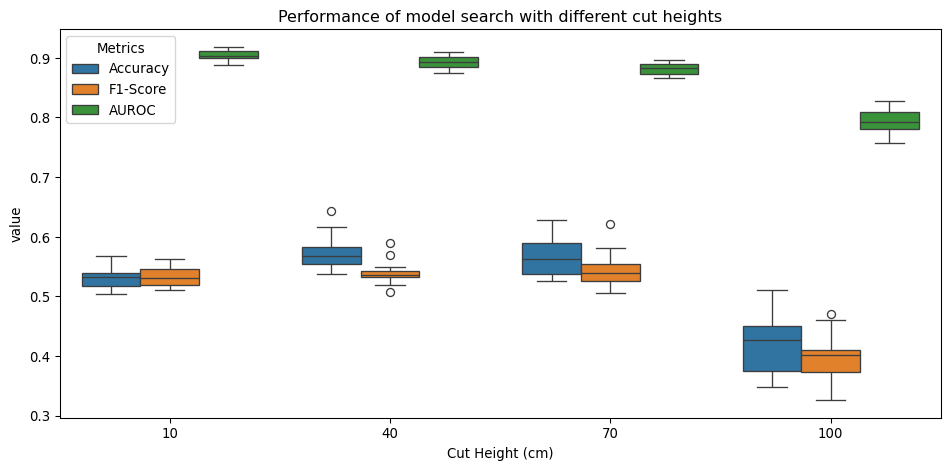

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=96)

result = {
    ch: {'Model': [], 'Accuracy': [], 'F1-Score': [], 'AUROC': []} for ch in cut_heights
}

pattern = r".+-TT-(.+)-None-.+-acc-([\d.]{5,6})-f1-([\d.]{5,6})-.+-auroc-([\d.]{5,6}).+" #

for n,ch in enumerate(cut_heights):
    for key in model_dict.keys():
        color = model_dict[key]['color']

        color_train = np.clip(np.add(color, (-.1, -.1, -.1, 0.)), 0, 1)
        color_val = np.clip(np.add(color, (.15, .15, .15, 0.)), 0, 1)

        for experiment_file in model_dict[key][f'files-{ch}']:
            # Get the metric values
            # res[0] = acc, res[1] = f1, res[2] = auroc -> all macro
            res = re.match(pattern, experiment_file)

            result[ch]['Model'].append(res[1])
            result[ch]['Accuracy'].append(float(res[2]))
            result[ch]['F1-Score'].append(float(res[3]))
            result[ch]['AUROC'].append(float(res[4]))

# Generate the dataframe
# df = pd.DataFrame(data=None, index=None, columns=['Cut Height', 'Accuracy', 'F1-Score', 'AUROC'])
df = []
for ch in cut_heights:
    df_aux = pd.DataFrame.from_dict(result[ch])
    df_aux['Cut Height'] = ch
    # df = pd.concat((df, df_aux))
    df.append(df_aux)
df = pd.concat(df)


plot_data = pd.melt(df, id_vars=['Cut Height'], value_vars=['Accuracy', 'F1-Score', 'AUROC'], var_name='Metrics')
plot = sns.boxplot(x='Cut Height', y='value' ,data=plot_data, hue='Metrics', ax=axs)

# plt.legend()
# axs[n].set_yscale('log')
# axs.set_ylim(0, 800)
axs.set_title(f'Performance of model search with different cut heights')
# axs.set_ylabel('Train and Validation loss')
axs.set_xlabel('Cut Height (cm)')

plt.tight_layout()
plt.show()

In [19]:
# Gerar pandas DF com os resultados dos modelos
df_10 = pd.DataFrame.from_dict(result[10])
df_10['Cut_Height'] = 10

df_40 = pd.DataFrame.from_dict(result[40])
df_40['Cut_Height'] = 40

df_70 = pd.DataFrame.from_dict(result[70])
df_70['Cut_Height'] = 70

df_100 = pd.DataFrame.from_dict(result[100])
df_100['Cut_Height'] = 100


result_df = pd.concat((df_10, df_40, df_70, df_100), axis='index').sort_values(by=['Cut_Height', 'F1-Score', 'Accuracy', 'AUROC'], ascending=[True, False, False, False])

In [20]:
result_df

,Model,Accuracy,F1-Score,AUROC,Cut_Height
12,resnet18,0.5588,0.5630,0.9165,10
2,mobilenet_v3_small,0.5676,0.5577,0.9142,10
9,resnet18,0.5617,0.5574,0.9080,10
5,regnet_y_800mf,0.5370,0.5524,0.9107,10
11,resnet18,0.5585,0.5462,0.9111,10
4,regnet_y_800mf,0.5267,0.5452,0.9056,10
16,shufflenet_v2_x1_5,0.5152,0.5333,0.9022,10
0,efficientnet_B0,0.5284,0.5324,0.9008,10
10,resnet18,0.5319,0.5307,0.9181,10
7,regnet_x_800mf,0.5217,0.5292,0.9064,10


In [12]:
result_df.to_excel('best-models-per-cut-height.xlsx', index=False, sheet_name='models')

In [13]:
best_models = pd.read_excel('./Best-performing-models-2024-09.xlsx')

In [14]:
best_models[best_models.Cut_Height == 40]

,Cut_Height,Well,Model,Optimizer,LR,Accuracy,F1-macro,F1-weighted
38,40,3-brsa-1201,regnet_x_800mf,Adam,1315,0.91,0.76,0.92
39,40,3-brsa-1201,regnet_y_800mf,Adam,1163,0.92,0.73,0.92
40,40,3-brsa-1201,resnet18,Adam,124,0.94,0.82,0.94
41,40,3-brsa-1201,shufflenet_v2_x1_5,Adam,437,0.94,0.75,0.94
42,40,7-ll-11,regnet_x_800mf,Adam,1315,0.92,0.78,0.93
43,40,7-ll-11,regnet_y_800mf,Adam,1163,0.94,0.82,0.94
44,40,7-ll-11,resnet18,Adam,124,0.95,0.92,0.95
45,40,7-ll-11,resnet18,SGD,9069,0.94,0.79,0.94
46,40,7-ll-11,shufflenet_v2_x1_5,Adam,437,0.94,0.79,0.94
47,40,7-ll-11,shufflenet_v2_x1_5,SGD,1439,0.90,0.59,0.90


In [15]:
best_models['Model'].unique()

array(['regnet_x_400mf', 'regnet_x_800mf ', 'regnet_y_800mf ',
       'resnet18 ', 'resnet18', 'shufflenet_v2_x1_5',
       'shufflenet_v2_x1_0', 'shufflenet_v2_x0_5', 'mobilenet_v3_small'],
      dtype=object)

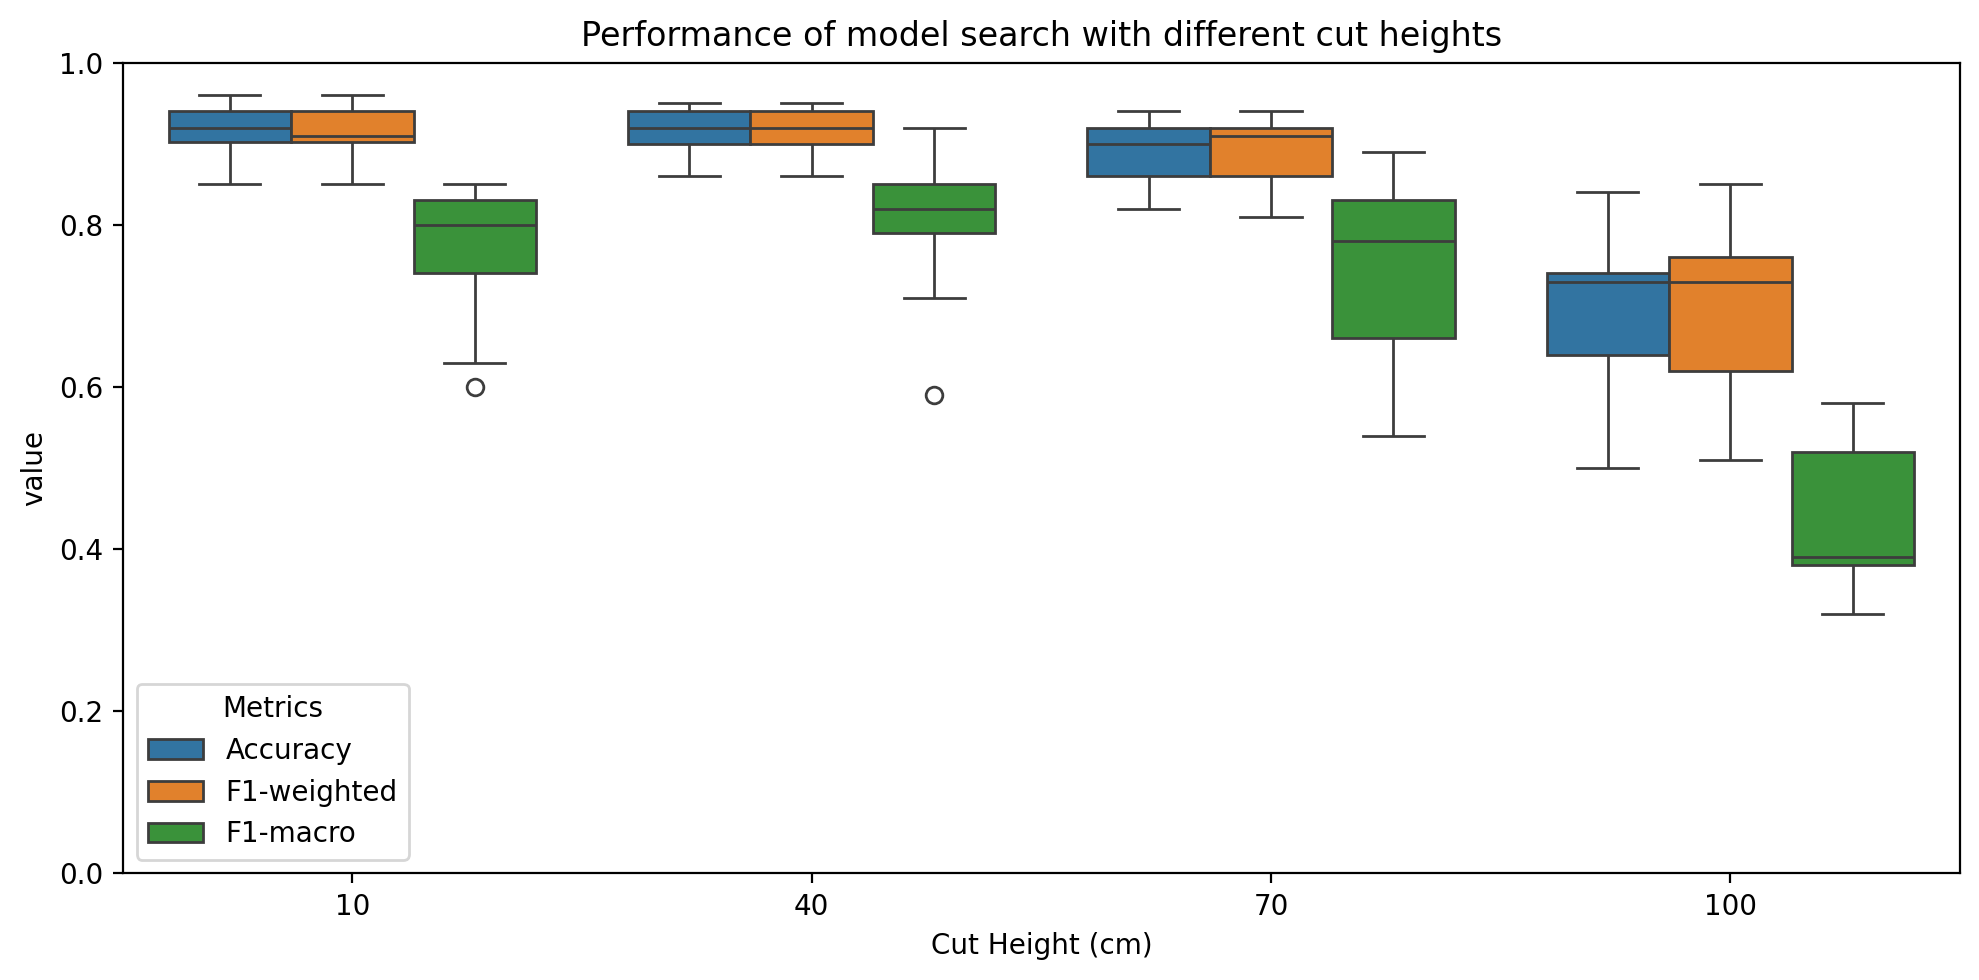

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=200)

plot_data = pd.melt(best_models, id_vars=['Cut_Height'], value_vars=['Accuracy', 'F1-weighted', 'F1-macro'], var_name='Metrics')
plot = sns.boxplot(x='Cut_Height', y='value' ,data=plot_data, hue='Metrics', ax=axs)

# plt.legend()
# axs[n].set_yscale('log')
# axs.set_ylim(0, 800)
axs.set_title(f'Performance of model search with different cut heights')
# axs.set_ylabel('Train and Validation loss')
axs.set_xlabel('Cut Height (cm)')
axs.set_ylim(0., 1.)

plt.tight_layout()
plt.show()

In [17]:
# Find the training loss curves of the best performing models
best_models = best_models.assign(Model_Training_Stats=None)

pattern = r".+-tt-(.+)-none-(.+)-lr-(0.\d{6})-.+"
def check_model(filename, model, optimizer, lr):
    _m, _o, _l = re.match(pattern, filename).groups()
    return model == _m and optimizer == _o and lr == _l

for ch in best_models['Cut_Height'].unique():
    basepath = f'./checkpoints-{ch}-single-label-final'

    all_models = [f for f in os.listdir(basepath) if f.endswith('xlsx')]
    for idx, row in best_models[best_models['Cut_Height'] == ch].iterrows():
        # print(row, idx)
        # raise Exception()
        current_model = [f for f in all_models if check_model(f.lower(), row['Model'].lower().strip(), row['Optimizer'].lower().strip(), f"{float(row['LR'])/1e6:.6f}")]
        try:
            best_models.loc[idx, 'Model_Training_Stats'] = current_model[0]
        except IndexError as e:
            print(idx, row)
            print(current_model)
            raise Exception(e)

/tmp/ipykernel_690/4053915496.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


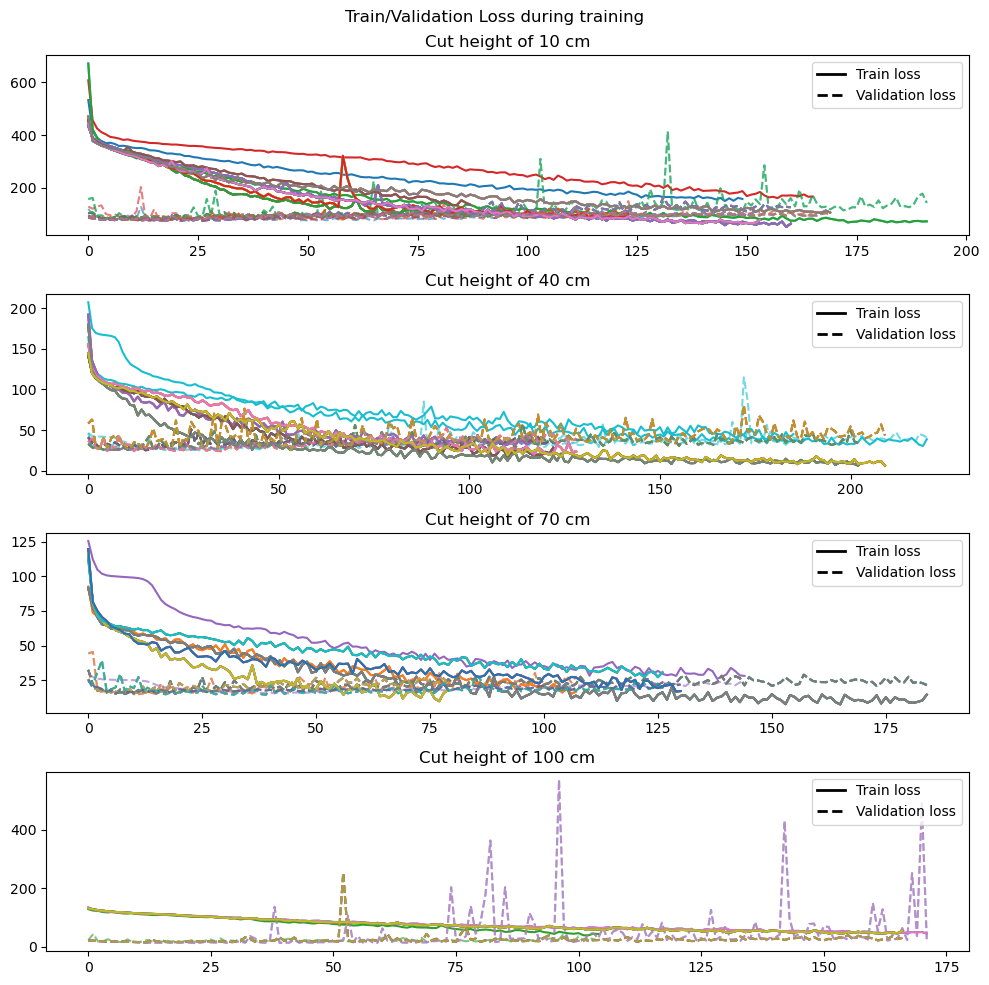

In [18]:
# Generate the loss curve using the filenames
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,10))
fig.suptitle('Train/Validation Loss during training')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=2, linestyle='-', label='Train loss'),
                   Line2D([0], [0], color='k', lw=2, linestyle='--', label='Validation loss'),
                ]

for n,ch in enumerate(best_models['Cut_Height'].unique()):
    axs[n].set_title(f'Cut height of {ch} cm')
    axs[n].legend(handles=legend_elements, loc='upper right')
    # metric_ax = axs[n].twinx()
    
    for idx, row in best_models[best_models['Cut_Height'] == ch].iterrows():
        losses = pd.read_excel(os.path.join(f'./checkpoints-{ch}-single-label-final', row['Model_Training_Stats']))[['train-loss', 'validation-loss', 'accuracy-macro', 'f1-macro']]
        tloss = axs[n].plot(range(losses['train-loss'].shape[0]), losses['train-loss'], linestyle='-', alpha=1.)[0]
        axs[n].plot(range(losses['validation-loss'].shape[0]), losses['validation-loss'], linestyle='--', color=tloss.get_color(), alpha=.6)
        # metric_ax.plot(range(losses['accuracy-macro'].shape[0]), losses['accuracy-macro'], linestyle='-.', color=tloss.get_color(), alpha=.6)

fig.tight_layout()
fig.show()